In [55]:
### notebook for homework 6
### Raja Batra and Eli Rejto
### October 5, 2023


In [56]:
import os
import numpy as np

If you fo not already have torch in your venv do: pip install torch

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [58]:
from torch.utils.data import Dataset, DataLoader

## data preperation process

#### I created two subdirectories for training data and validation data. I used 35 pictures for the training and 15 for validation out. of the 50. So 0.7 training and 0.3 validation. I then transformed the images to 224 by 224 pixels and made them into tensors

In [59]:

#training_data = 'hw6_data/training_data'
#validation_data = 'hw6_data/validation_data'
data = 'hw6_data'


In [60]:
imgtransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [61]:
dataset = torchvision.datasets.ImageFolder(root=data, transform=imgtransform)

##### function just to display images

In [62]:
def showImages(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
labels:  tensor([1, 2, 0, 1, 3, 3])


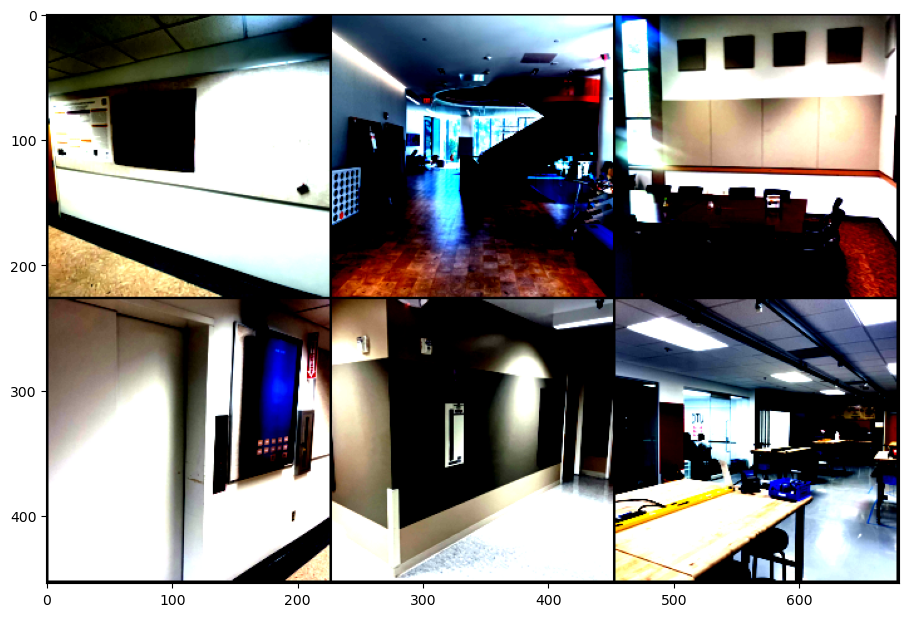

In [63]:
showImages(dataset)

In [64]:
validation_pct = 0.2
num_samples = len(dataset)
num_valid = int(validation_pct * num_samples)
num_train = num_samples - num_valid

In [65]:
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [num_train, num_valid])

In [79]:
train_data = DataLoader(train_dataset, batch_size=5, shuffle=True)
validation_data = DataLoader(validation_dataset, batch_size=5, shuffle=False)

## Nearest Neighbor Approach

#### Uses the resnet50 pretrained model from pytorch. Puts our images through the model and extracts the 1000 out features from the last linear layer. This is done unsqueezing the image which adds another dimension to the image allowing the tensor to be passed through the pretrained model. Then I squeeze the output and return the 1000 features. 

In [84]:
import torchvision.models as models

In [85]:
model = models.resnet50(pretrained=True)
model = model.eval()  

In [86]:
def extract_features(model, image):
    # Preprocess the image and extract features

    with torch.no_grad():
        features = model(image.unsqueeze(0)) 
        
    return features.squeeze()

In [87]:
train_features = []
train_labels = []

In [88]:
##do feature extraction
for images, labels in train_data:
    for image, label in zip(images, labels):
        features = extract_features(model, image)
        train_features.append(features.numpy())
        train_labels.append(label)

In [89]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [90]:
print(train_features.shape)

(200, 1000)


In [91]:
print(train_labels)

[0 4 1 1 4 4 4 3 2 1 4 0 2 4 4 1 0 0 1 0 2 2 1 4 1 1 3 3 4 2 2 3 3 4 1 4 0
 4 3 1 2 2 1 1 2 4 4 3 4 2 4 2 1 0 3 0 3 0 4 0 4 2 1 2 0 4 0 0 0 3 0 0 4 2
 1 1 0 3 4 2 1 3 3 3 3 4 1 1 0 4 2 2 4 3 3 1 0 4 2 4 1 2 1 4 3 2 1 4 1 1 2
 1 0 2 2 3 3 3 0 0 3 1 0 2 3 2 0 3 2 0 2 4 1 2 1 4 2 2 0 0 2 1 4 0 2 2 0 4
 4 1 4 1 4 1 0 3 0 4 2 4 4 2 3 4 2 4 4 4 4 3 3 3 1 3 3 0 2 3 0 1 0 1 1 1 4
 3 0 3 3 2 1 1 0 2 3 0 1 1 2 0]


In [92]:
validfeatures = []
validlabels = []
predictions = []
for images, labels in validation_data:
    for image, label in zip(images, labels):
        features = extract_features(model, image)
        validfeatures.append(features.numpy())
        validlabels.append(label)

        ##the euclidean distance
        
        distances = np.linalg.norm(train_features - features.numpy(), axis=1)
        
        closest_index = np.argmin(distances)
       
        prediction = train_labels[closest_index]
        predictions.append(prediction)

validfeatures = np.array(validfeatures)
validlabels = np.array(validlabels)
predictions = np.array(predictions)



In [93]:
correct_predictions = 0
total_predictions = len(validlabels)
accuracy = np.mean((predictions==validlabels))
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 71.43%


# Part 3

In [94]:
import torch.nn as nn

In [41]:
# class Finetunemodel(nn.Module):
#     def __init__(self, in_features, num_classes):
#         super(Finetunemodel, self).__init__()
#         self.fc = nn.Linear(in_features, num_classes)
#         self.softmax = nn.Softmax(dim=1)  

#     def forward(self, x):
#         x = self.fc(x)
#         x = self.softmax(x)  
#         return x

In [42]:
# model = torchvision.models.resnet50(pretrained=True)
# in_features = model.fc.in_features
# model = nn.Sequential(*list(model.children())[:-1])
# num_classes = 5
# classifier = Finetunemodel(in_features, num_classes)
# model = nn.Sequential(model, classifier)

In [99]:
#Using this post as a guideline for the code
#https://discuss.pytorch.org/t/feature-extraction-fine-tuning-in-resnet50/119387
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
   param.requires_grad = False
# model_no_output_layer = torch.nn.Sequential(*(list(model.children())[:-1]))
input_features = 2048
num_classes = 5
#model = nn.Sequential(*list(model.children())[:-1])
model.fc = torch.nn.Sequential(torch.nn.Dropout(),
                          torch.nn.Linear(input_features, num_classes))


num_epochs = 100
criterion = nn.CrossEntropyLoss()
#print(model)
optimizer = torch.optim.SGD(model.fc.parameters(),lr= 0.01)

total_loss = []
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    model.train()
    
   
    train_loss = 0.0
   
    for images, labels in train_data:

        
        # Forward pass
        outputs = model(images)
        #_, pred = torch.max(outputs, 1)
       
        #pred = pred.type(torch.FloatTensor)
        #labels = labels.type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        #loss = criterion(loss, requires_grad = True)
       
        # Backward and optimize
        optimizer.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
       
    train_loss /= len(train_data)
    train_losses.append(train_loss)
    
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_data:
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            #pred = pred.type(torch.FloatTensor)
            #labels = labels.type(torch.FloatTensor)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            #print(pred)
            
        
    valid_loss /= len(validation_data)
    valid_losses.append(valid_loss)
       

    

    print(f'Epoch [{epoch + 1}/{num_epochs}]'
              f' Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f},'
              f' Accuracy: {100 * correct / total:.2f}%')

model.eval()
torch.save()






RuntimeError: expected scalar type Long but found Float